# Kweather 데이터에 대한 관찰 코드

https://www.kaggle.com/izzettunc/introduction-to-time-series-clustering

## 1. Parameter Setting

In [9]:
import sys
sys.path.append("../")
sys.path.append("../..")

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(14, 4)

# 1.Data ingestion parameter
import pandas as pd
from datetime import timedelta
duration_day = 1 # 1 or 7
start_time = pd.to_datetime("2020-05-14 00:00:00")
end_time = start_time + timedelta(days = duration_day)
duration = {'start_time':start_time, 'end_time':end_time}
db_name = 'air_indoor_도서관'
feature_list = ['in_co2']# ['in_noise','in_pm01', 'in_pm01_raw', 'in_pm10', 'in_pm10_raw', 'in_pm25','in_pm25_raw', 'in_temp', 'voc']
feature_name = feature_list[0]


fig_width_num = 4
fig_width = 30
fig_height = 30


# 2.Data manipulation parameter
freq_min = 60
import datetime
timedelta_frequency_min = datetime.timedelta(minutes= freq_min)
# 3. Nan Processing Parameter
# 3-1. NanLImitProcessingInfo = {'type':'ratio', 'ConsecutiveNanLimit':0.05, 'totalNaNLimit':1} # seconds
# 3-2. NanLImitProcessingInfo = {'type':'time', 'ConsecutiveNanLimit':1*60*60, 'totalNaNLimit':5*60*60} #seconds
# 3-3.
NanInfoForClenData = {'type':'num', 'ConsecutiveNanLimit':100, 'totalNaNLimit':100}

## 1. dataset Prepration

In [10]:
from clust.ingestion.influx import influx_Client_v2 as influx_Client, multipleDataSets
from setting import influx_setting_KETI as ins
db_client = influx_Client.influxClient(ins.CLUSTDataServer2)
dataSet = multipleDataSets.get_all_msdata_in_bucket(start_time, end_time, db_client, db_name)

/home/jwmoon/.local/lib/python3.8/site-packages/influxdb_client/client/warnings.py:31: MissingPivotFunction: The query doesn't contains the pivot() function.

The result will not be shaped to optimal processing by pandas.DataFrame. Use the pivot() function by:

    import "influxdata/influxdb/schema" schema.measurements(bucket: "air_indoor_도서관") |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")

You can disable this warning by:
    import warnings
    from influxdb_client.client.warnings import MissingPivotFunction

    warnings.simplefilter("ignore", MissingPivotFunction)

For more info see:
    - https://docs.influxdata.com/resources/videos/pivots-in-flux/
    - https://docs.influxdata.com/flux/latest/stdlib/universe/pivot/
    - https://docs.influxdata.com/flux/latest/stdlib/influxdata/influxdb/schema/fieldsascols/

  warnings.warn(message, MissingPivotFunction)


## 2. preprocessing (refinement, error handling)

In [11]:
from Clust.clust.preprocessing.custom.simple import preprocessing_basic_for_clust_multiDataSet
from Clust.clust.ingestion.mongo import mongo_Client
mongo_client = mongo_Client.mongoClient(ins.CLUSTMetaInfo2)
dataSet_pre = preprocessing_basic_for_clust_multiDataSet(dataSet, mongo_client, db_name, timedelta_frequency_min)

## 3. get one dataframe 

In [12]:
from Clust.clust.transformation.general import dataframe
dataDF = dataframe.get_oneDF_with_oneFeature_from_multipleDF(dataSet_pre, feature_name, duration, timedelta_frequency_min)

## 4. remove bad column

In [13]:
from Clust.clust.quality.NaN import cleanData
CMS = cleanData.CleanData()
data = CMS.get_cleanData_by_removing_column(dataDF, NanInfoForClenData) 

5 ---> 5


In [25]:
data

,ICW0W2000087,ICW0W2000088,ICW0W2000089,ICW0W2000128,ICW0W2000129
0,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000000,1.000000,1.000000,1.000000,1.000000
2,1.000000,1.000000,1.000000,1.000000,1.000000
3,1.000000,1.000000,1.000000,1.000000,1.000000
4,1.000000,1.000000,1.000000,1.000000,1.000000
5,1.000000,1.000000,1.000000,1.000000,1.000000
6,1.000000,1.000000,1.000000,1.000000,1.000000
7,1.000000,1.000000,1.000000,1.000000,1.000000
8,1.000000,1.000000,1.000000,1.000000,1.000000
9,1.000000,1.000000,1.000000,1.000000,1.000000


## 5. Clustering

### 5-1. Preprocessing for clustering

In [22]:
from Clust.clust.preprocessing.custom.simple import preprocessing_smoothing_scaling
data = preprocessing_smoothing_scaling(data, ewm_parameter=0.3)

In [23]:
data

,ICW0W2000087,ICW0W2000088,ICW0W2000089,ICW0W2000128,ICW0W2000129
0,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000000,1.000000,1.000000,1.000000,1.000000
2,1.000000,1.000000,1.000000,1.000000,1.000000
3,1.000000,1.000000,1.000000,1.000000,1.000000
4,1.000000,1.000000,1.000000,1.000000,1.000000
5,1.000000,1.000000,1.000000,1.000000,1.000000
6,1.000000,1.000000,1.000000,1.000000,1.000000
7,1.000000,1.000000,1.000000,1.000000,1.000000
8,1.000000,1.000000,1.000000,1.000000,1.000000
9,1.000000,1.000000,1.000000,1.000000,1.000000


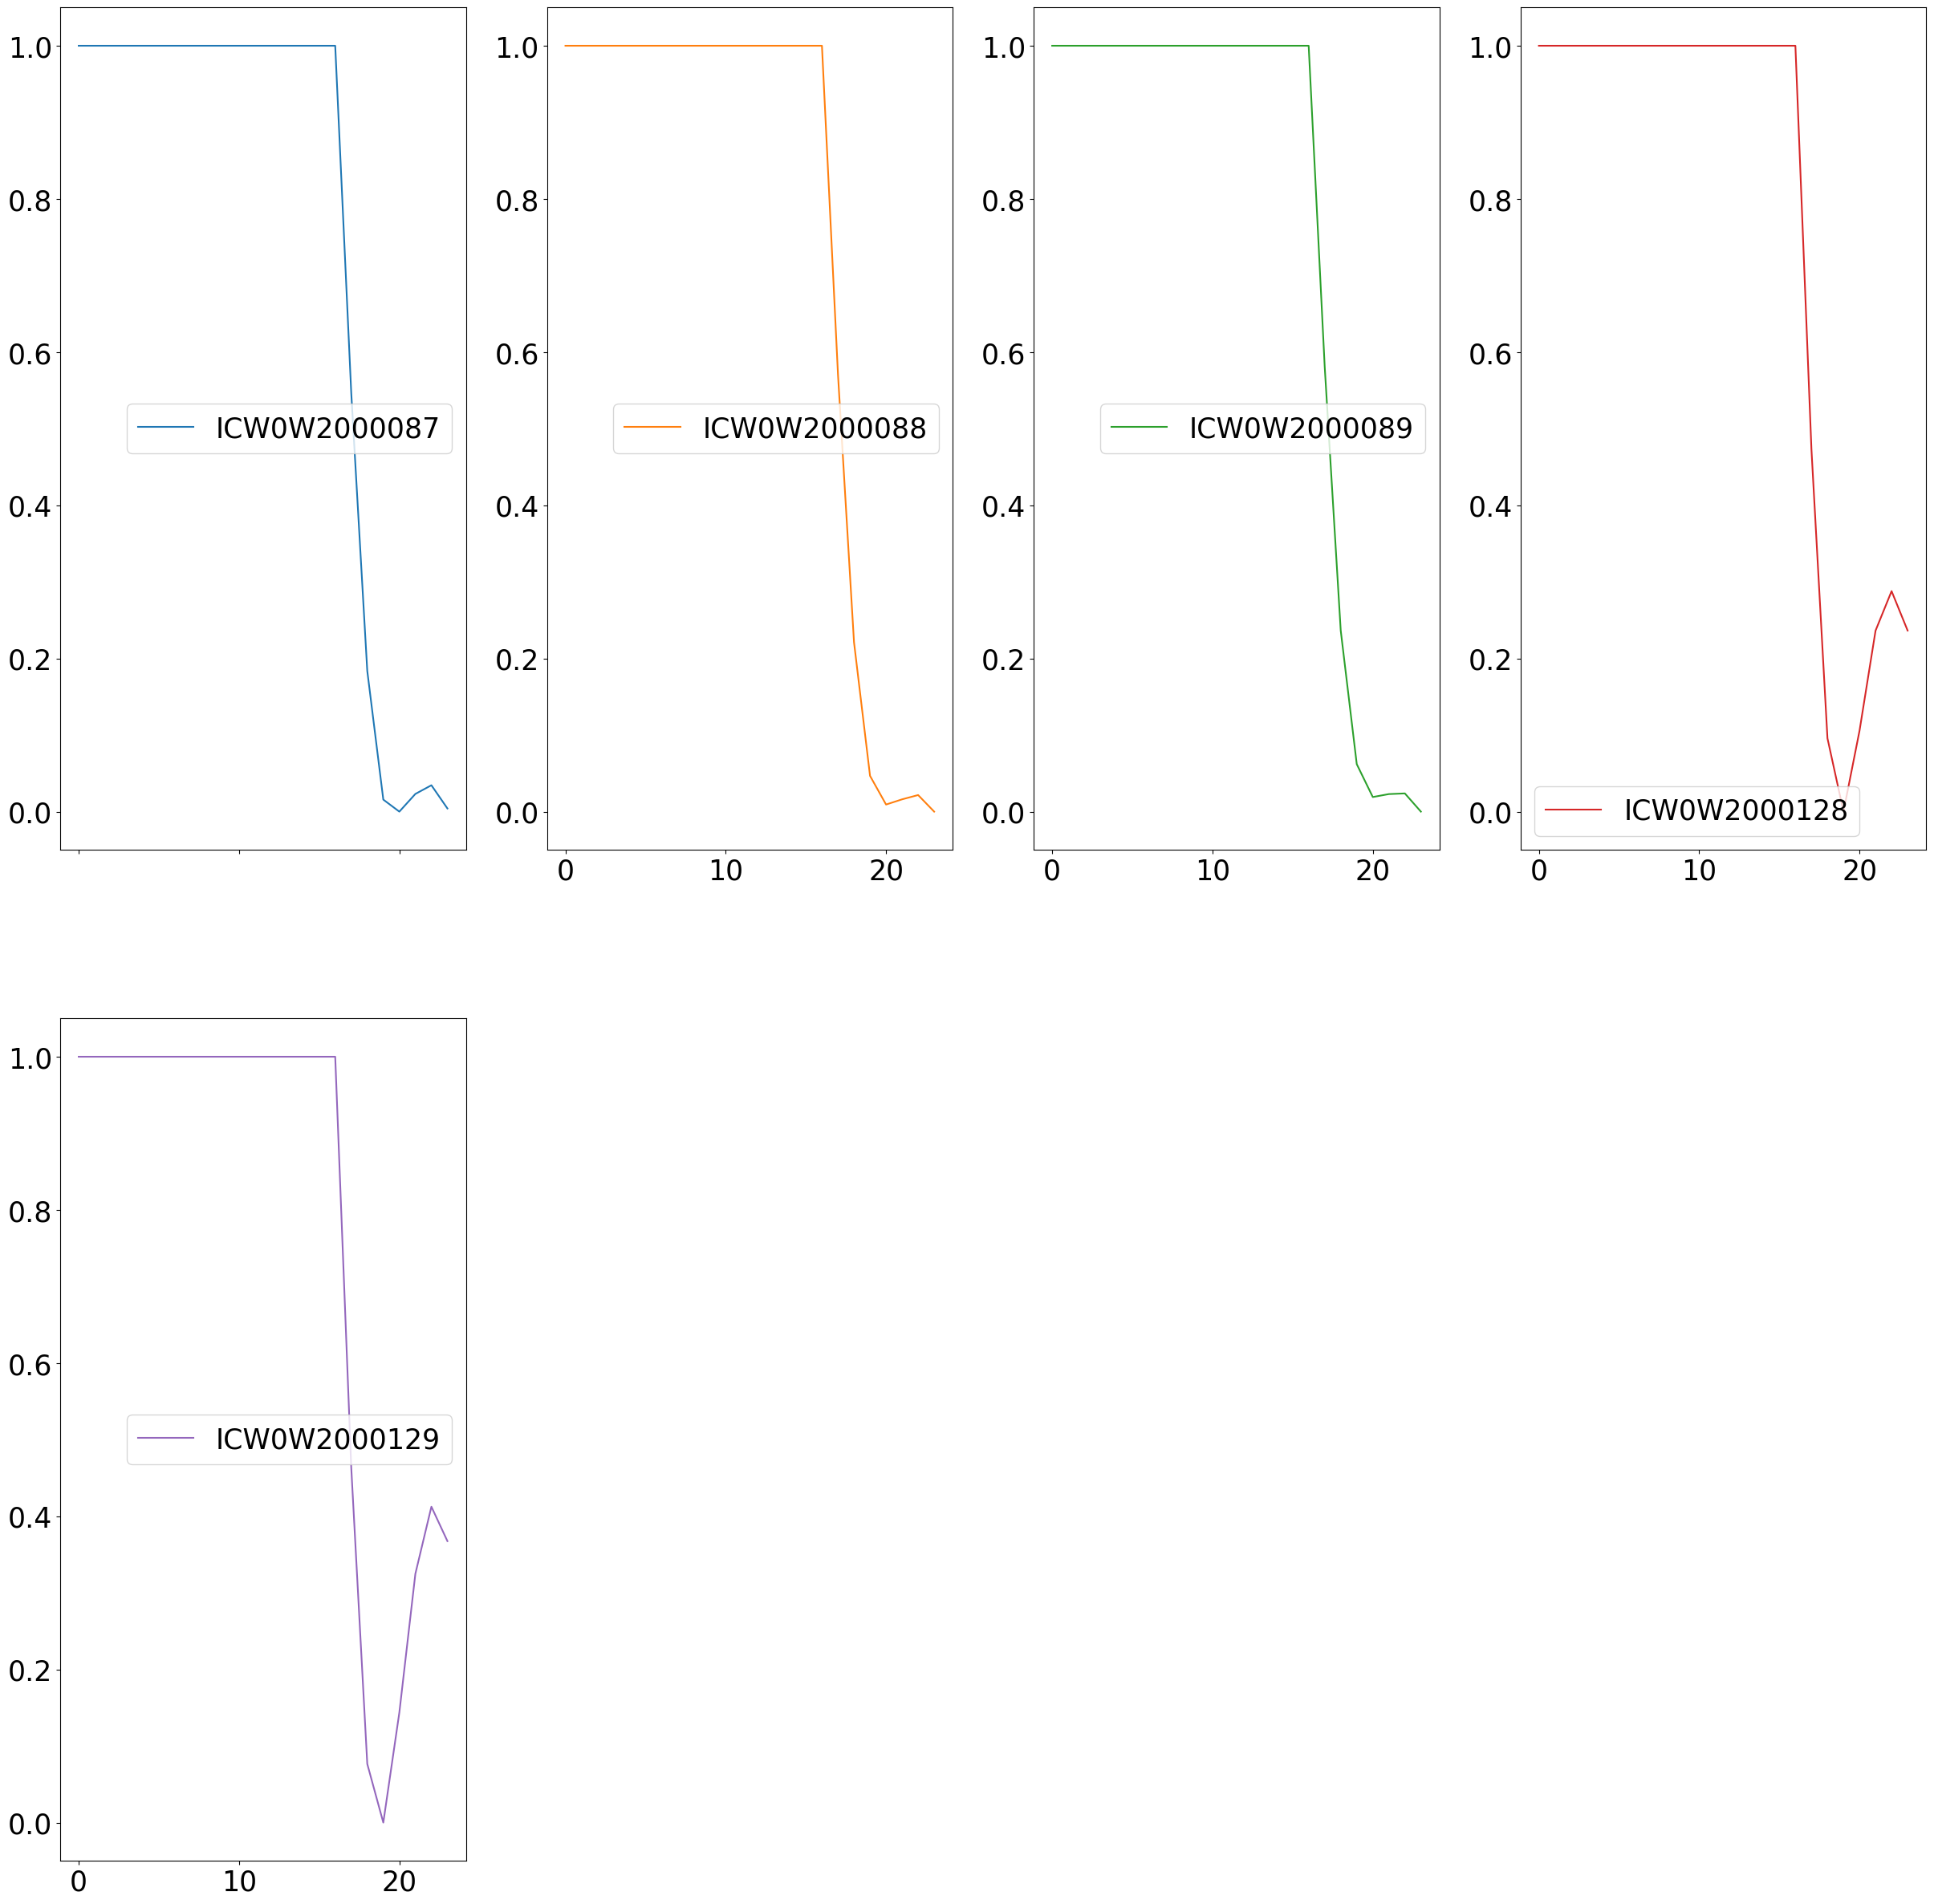

In [24]:
from Clust.clust.tool.plot_graph import plot_features
plot_features.plot_all_column_data_inSubPlot(data, fig_width, fig_height, fig_width_num = 4)

### 5-2. Som Clustering

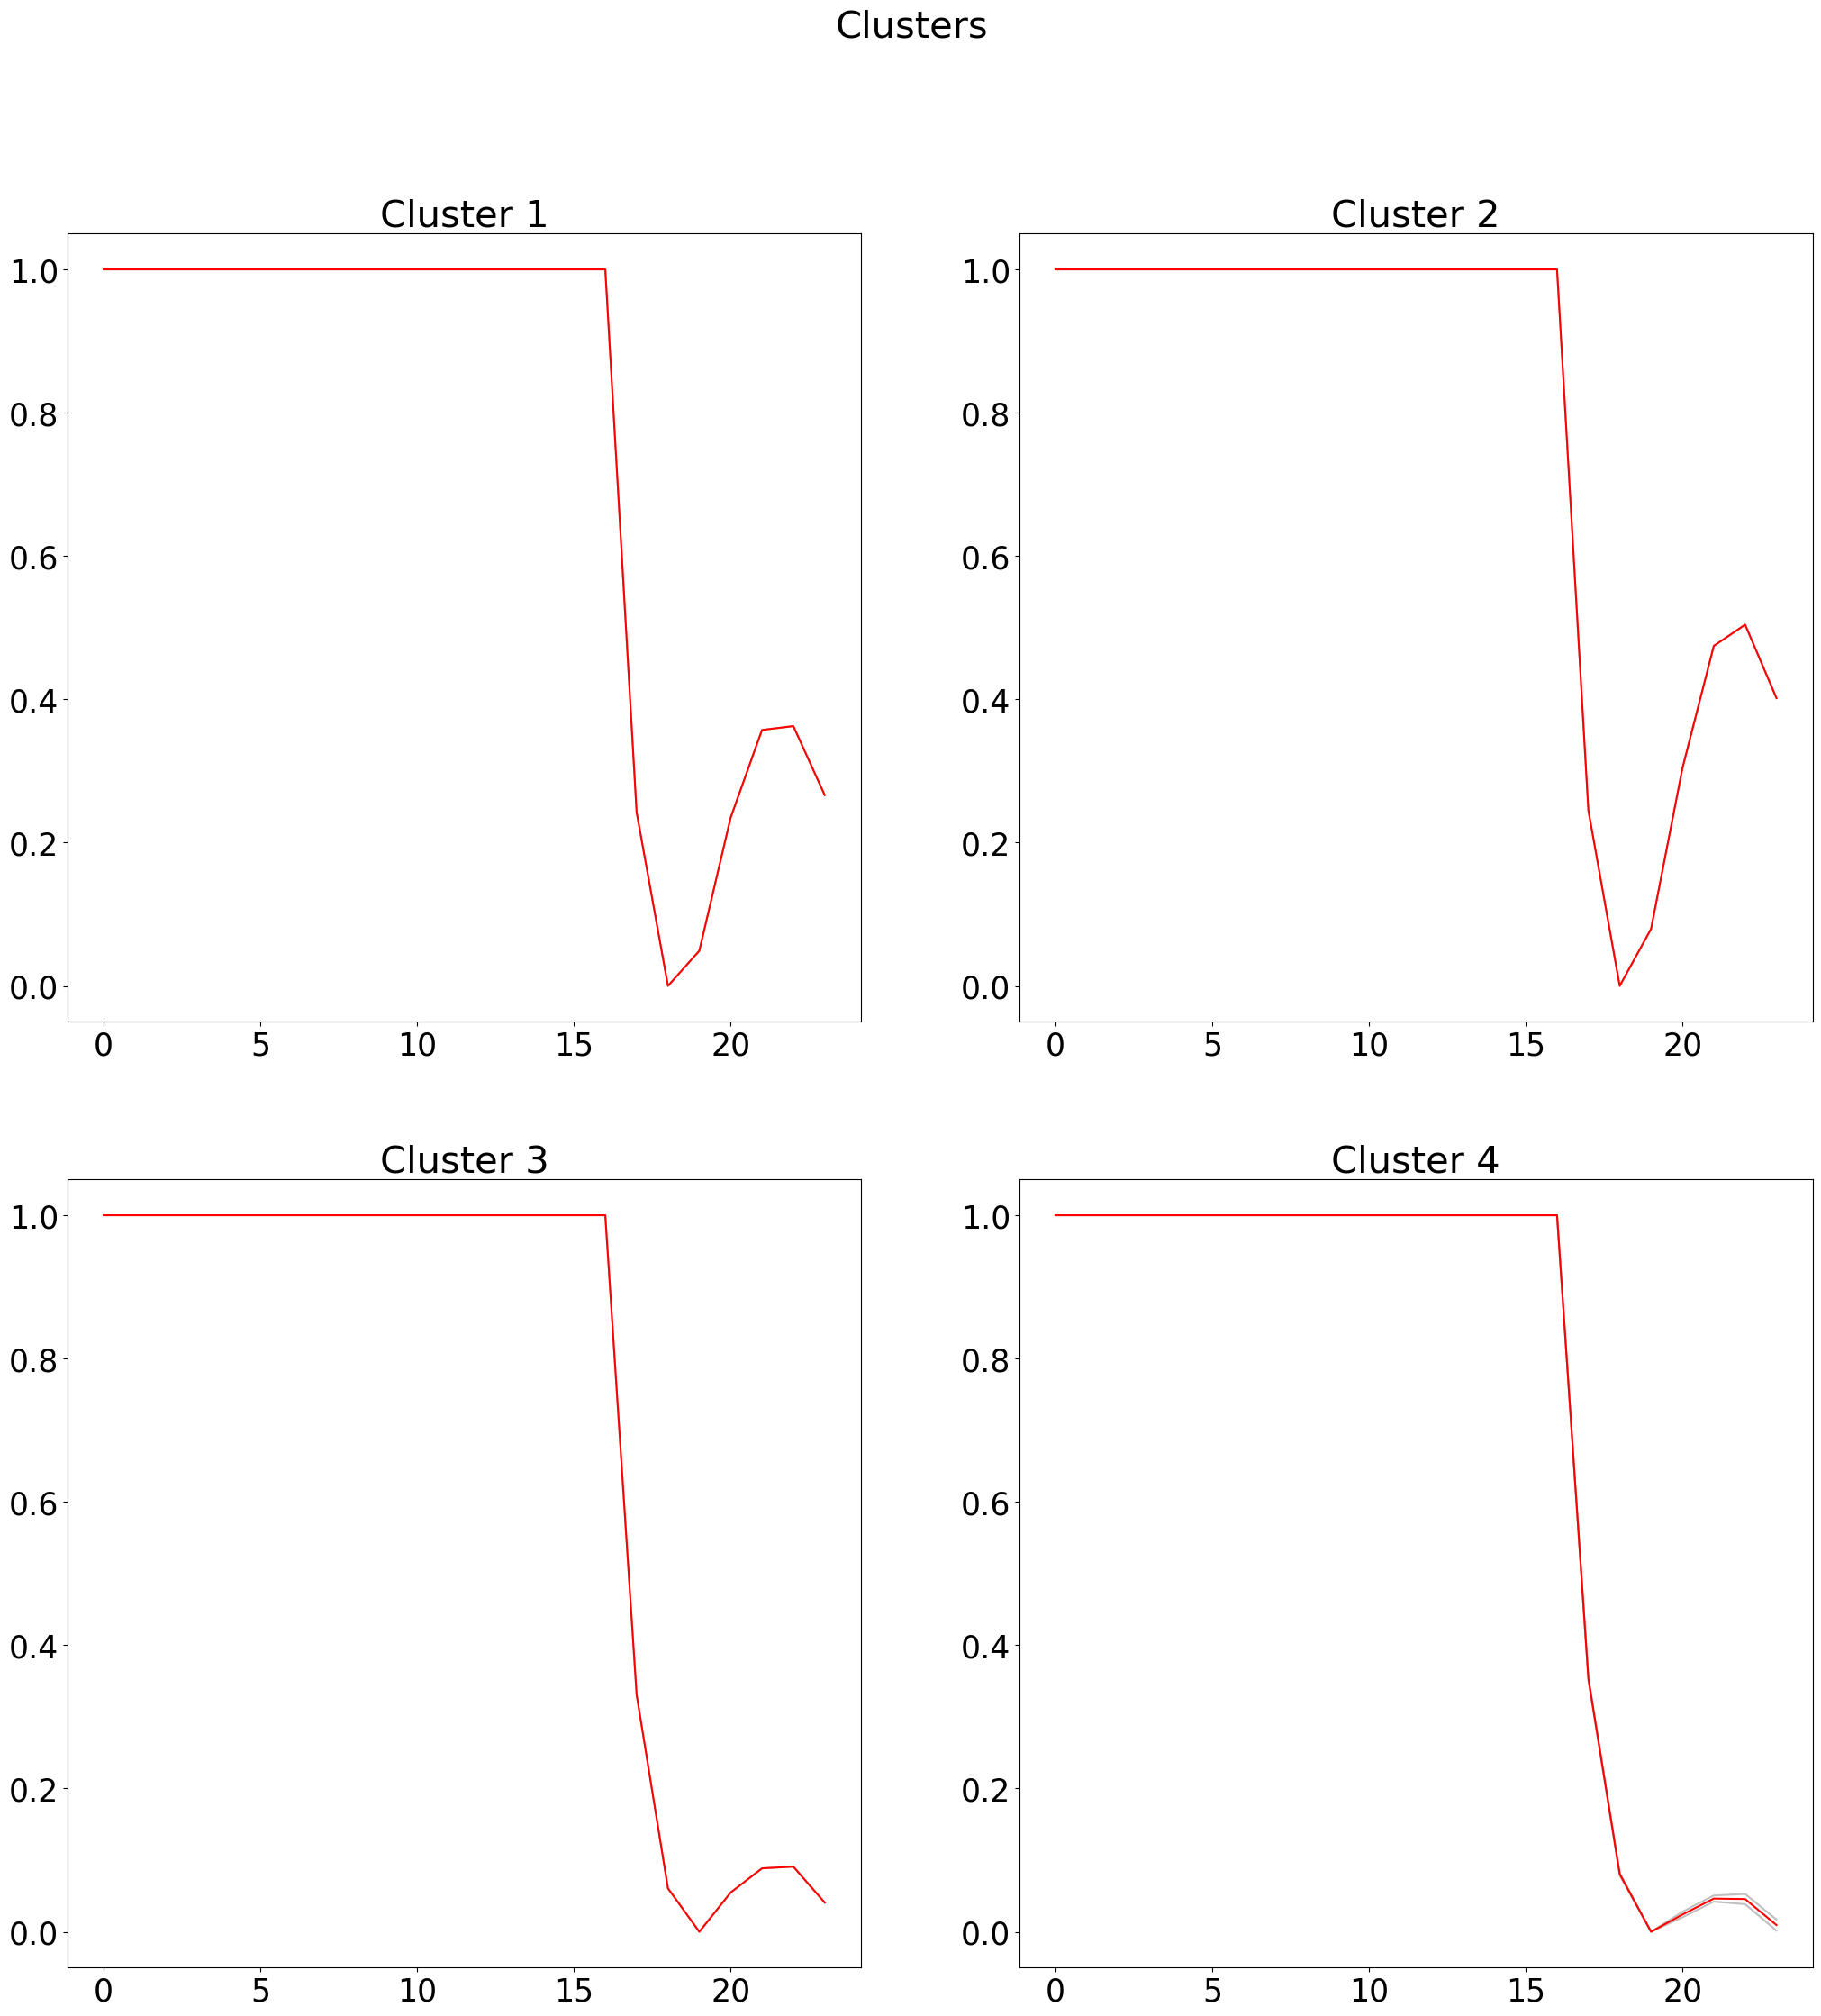

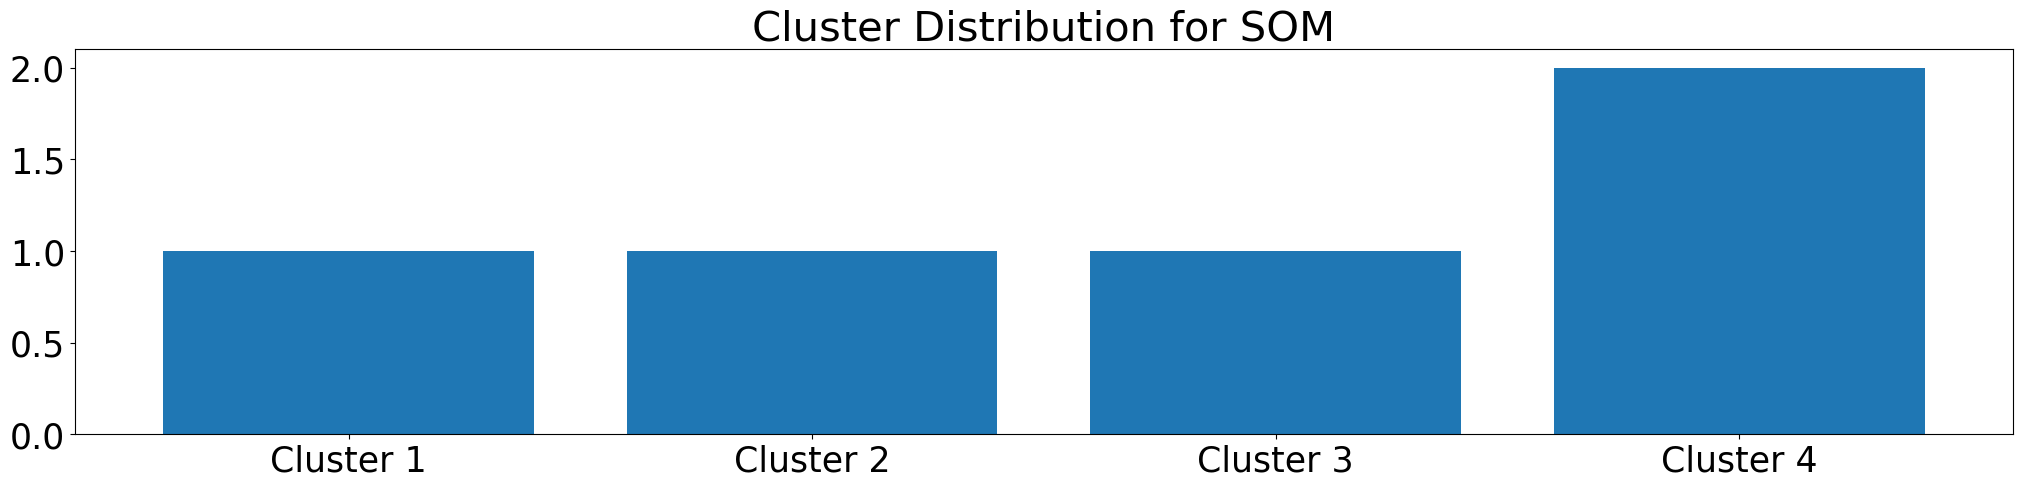

In [17]:
from Clust.clust.ML.clustering.interface import clusteringByMethod
result, figdata, figdata2 = clusteringByMethod(data, 'som',  2, 2)
plt.show()

In [18]:
result

{'ICW0W2000087': '3',
 'ICW0W2000088': '4',
 'ICW0W2000089': '4',
 'ICW0W2000128': '1',
 'ICW0W2000129': '2'}